##Installing required packages

In [ ]:
!pip install ml-datasets

In [ ]:
!python -m spacy download en_core_web_md

2021-04-20 05:40:50.108840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 47.1MB 157kB/s 
  Found existing installation: en-core-web-md 2.2.5
    Uninstalling en-core-web-md-2.2.5:
      Successfully uninstalled en-core-web-md-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
!pip install spacy==3.0.3

     |████████████████████████████████| 12.7MB 21.2MB/s 
     |████████████████████████████████| 1.1MB 51.1MB/s 
     |████████████████████████████████| 9.1MB 51.4MB/s 
     |████████████████████████████████| 460kB 48.4MB/s 
     |████████████████████████████████| 122kB 50.0MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=a12686645f8e309c90aff5a6a7ef0419c428e1063052076a83f898c66b0d2dfb
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: smart-open 5.0.0
    Uninstalli

## Import modules

In [ ]:
import spacy
from tqdm.auto import tqdm
from spacy.tokens import DocBin
from ml_datasets import imdb
import matplotlib.pyplot as plt

## Loading model and IMDB dataset

In [ ]:
# load a medium sized english language model in spacy
nlp = spacy.load('en_core_web_md')
print(spacy.__version__)
print(nlp.pipe_names)

3.0.3
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']


In [ ]:
# load movie reviews as a tuple (text, label)
train_data, valid_data = imdb()
print(train_data[:2])
print(valid_data[:2])

[("This film has a lot of raw potential. The script is sharp, the dialogue is (usually) excellent (though it could stand to lose the cheezy voice-overs), the direction and cinematography is surprisingly quite good, though some of the experimentation just doesn't work. The main problem here is David Duchovny. Once a geek-boy, always a geek-boy; and the sad, simple fact is that he's incapable of playing anything but Fox Mulder. He postures, he tries to be slick, he poses, he tries to be macho. In the end he just tries too hard. He overplays his character, he overspeaks his lines, and he's just outplayed in all ways by Timothy Hutton and Angelina Jolie, who are each in a class above him in terms of acting skill. Timothy Hutton was (as always) really good. There was a spotty moment or two where he over-dramatized his role, but you could tell he was having fun with it. He looked the part, and he became the character both physically and atmospherically. Angelina Jolie was also really good. S

## Functions

In [ ]:
def make_docs(data):
    """
    this will take a list of texts and labels 
    and transform them in spacy documents
    
    data: list(tuple(text, label))
    
    returns: List(spacy.Doc.doc)
    """
    
    docs = []
    # nlp.pipe([texts]) is way faster than running 
    # nlp(text) for each text
    # as_tuples allows us to pass in a tuple, 
    # the first one is treated as text
    # the second one will get returned as it is.
    
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        
        # we need to set the (text)cat(egory) for each document
        if label == 'pos':
          doc.cats["categories"] = 1
        else:
          doc.cats["categories"] = 0
        
        # put them into a nice list
        docs.append(doc)
    
    return docs

In [ ]:
def score(data,nlp):
  '''
      This function takes the labeled arguments and nlp objects and returns thresolds, precion, recall and all scores
      Args : 
            data - (list (text,label))
            nlp - (nlp object)
      Returns :
            thresolds - list of thresolds in range 0 to 1, stepsize 0.1
            precison - list of precisions for different thresolds
            recall - list of recalls for different thresolds
            all_result - list of dcitionaries containing tn,fp,fn,tp for different thresolds

  '''
  thresolds = [x / 10.0 for x in range(0, 11, 1)]
  precision = []
  recall = []
  result = {}
  all_result = []
  predicted_label = []
  true_label = []
  fpr = []
  for thresold in tqdm(thresolds, total = len(thresolds)):
    for doc, label in nlp.pipe(data, as_tuples=True):
      if doc.cats['categories']>thresold:
        predicted_label.append('pos')
        true_label.append(label)
      else:
        predicted_label.append('neg')
        true_label.append(label)
    
      for y_true,y_pred in list(zip(true_label,predicted_label)):
        if y_true == 'neg' and y_pred == 'neg':
          if 'tn' in result.keys():
            result['tn'] += 1
          else:
            result['tn'] = 1
        if y_true == 'neg' and y_pred == 'pos':
          if 'fp' in result.keys():
            result['fp'] += 1
          else:
            result['fp'] = 1
        if y_true == 'pos' and y_pred == 'neg':
          if 'fn' in result.keys():
            result['fn'] += 1
          else:
            result['fn'] = 1
        if y_true == 'pos' and y_pred == 'pos':
          if 'tp' in result.keys():
            result['tp'] += 1
          else:
            result['tp'] = 1
    all_result.append(result)

    if 'fp' not in result.keys():
      precision.append(1)
    else:
      precision.append(result['tp']/(result['tp']+result['fp']))
      
    if 'fn' not in result.keys():
      recall.append(1)
    else:
      recall.append(result['tp']/(result['tp']+result['fn']))

    if 'fp' not in result.keys():
      fpr.append(0)
    elif 'tn' not in result.keys():
      fpr.append(1)
    else:
      fpr.append(result['fp']/(result['fp']+result['tn']))
      
  return thresolds,precision,recall,fpr,all_result

## Preparing train and test data

In [ ]:
num_training_texts = 10000

train_docs = make_docs(train_data[:num_training_texts])
print(train_docs[:2])


[This film has a lot of raw potential. The script is sharp, the dialogue is (usually) excellent (though it could stand to lose the cheezy voice-overs), the direction and cinematography is surprisingly quite good, though some of the experimentation just doesn't work. The main problem here is David Duchovny. Once a geek-boy, always a geek-boy; and the sad, simple fact is that he's incapable of playing anything but Fox Mulder. He postures, he tries to be slick, he poses, he tries to be macho. In the end he just tries too hard. He overplays his character, he overspeaks his lines, and he's just outplayed in all ways by Timothy Hutton and Angelina Jolie, who are each in a class above him in terms of acting skill. Timothy Hutton was (as always) really good. There was a spotty moment or two where he over-dramatized his role, but you could tell he was having fun with it. He looked the part, and he became the character both physically and atmospherically. Angelina Jolie was also really good. Sh

In [ ]:
#save training data into spacyV3 format
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("/content/data/train.spacy")

In [ ]:
# preparing validation data
num_validation_text = 2500
valid_docs = make_docs(valid_data[:num_validation_text])
doc_bin = DocBin(docs=valid_docs)
doc_bin.to_disk("./data/valid.spacy")

In [ ]:
total_positives_training = len([train_docs[i].cats['categories'] for i in range(len(train_docs)) if train_docs[i].cats['categories'] == 1])
total_negatives_training = len([train_docs[i].cats['categories'] for i in range(len(train_docs)) if train_docs[i].cats['categories'] == 0])
total_postives_valid = len([valid_docs[i].cats['categories'] for i in range(len(valid_docs)) if valid_docs[i].cats['categories'] == 1])
total_negatives_valid = len([valid_docs[i].cats['categories'] for i in range(len(valid_docs)) if valid_docs[i].cats['categories'] == 0])
print("Total positives in training set :",total_positives_training)
print("Total negatives in training set :",total_negatives_training)
print("Total positives in validation set :",total_postives_valid)
print("Total negatives in validation set :",total_negatives_valid)

Total positives in training set : 5047
Total negatives in training set : 4953
Total positives in validation set : 1244
Total negatives in validation set : 1256


In [ ]:
!python -m spacy train config.cfg --output ./output --paths.train ./data/train.spacy --paths.dev ./data/valid.spacy --gpu-id 0

2021-04-20 11:21:35.203529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Set up nlp object from config
Pipeline: ['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'textcat']
Created vocabulary
Finished initializing nlp object
Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler',
'lemmatizer', 'textcat']
ℹ Frozen components: ['tok2vec', 'tagger', 'parser', 'ner',
'attribute_ruler', 'lemmatizer']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  TAG_ACC  SENTS_F  ENTS_F  ENTS_P  ENTS_R  LEMMA_ACC  CATS_SCORE  SCORE 
---  ------  ------------  -------  -------  ------  ------  ------  ---------  ----------  ------
  0       0          0.2

## Evaluating the model

In [ ]:
nlp =  spacy.load("./output/model-best")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'textcat']


In [ ]:
num_validation_text = 1250
data = valid_data[:num_validation_text]
thresolds,precision,recall,fpr,scores= score(data,nlp)

In [ ]:
test_docs = make_docs(data)
test_postives_valid = len([test_docs[i].cats['categories'] for i in range(len(test_docs)) if test_docs[i].cats['categories'] == 1])
test_negatives_valid = len([test_docs[i].cats['categories'] for i in range(len(test_docs)) if test_docs[i].cats['categories'] == 0])
test_postives_valid,test_negatives_valid

(620, 630)

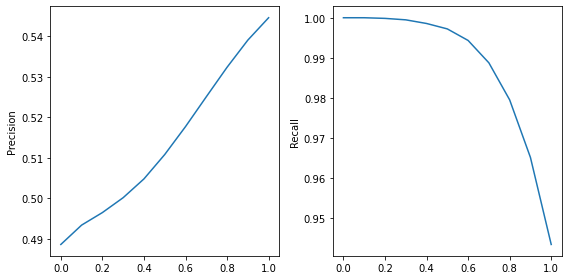

In [ ]:
plt.figure(figsize =(8,4))
plt.subplot(1,2,1)
plt.plot(thresolds,precision)
plt.ylabel('Precision')
plt.subplot(1,2,2)
plt.plot(thresolds,recall)
plt.ylabel('Recall')
plt.tight_layout()

Text(0, 0.5, 'TPR/Recall')

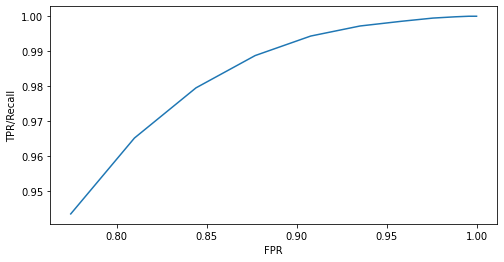

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(fpr,recall)
plt.xlabel('FPR')
plt.ylabel('TPR/Recall')

## Download model zip

In [ ]:
!zip -r /content/output.zip /content/output